### Import Section

In [81]:
# import necessay modules
import numpy as np
import torch
import torchinfo
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment by creating mini batches etc.
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from tqdm import tqdm # for nice loading
import matplotlib.pyplot as plt
import os
import itertools

### Config Section

In [82]:
# device config
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Hyper Parameter

In [83]:
NUM_WORKERS = 2
BATCH_SIZE = 20
PIN_MEMORY = True
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_PATH = "checkpoints/mnist_checkpoint.pth.tar"
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.001
NUM_EPOCHS = 3
VALID_SIZE= .2

### Data Processing Section

In [84]:
def get_dataloader(batch_size, num_workers=0):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )

    test_data = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )

    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )

    # load test data in batches
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )

    return train_loader, test_loader, valid_loader

### Data visalization

In [85]:
## Visualize data
def plot_dataset(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images = images.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        # print out the correct label for each image
        ax.set_title(str(labels[idx].item()))

    plt.show()  

In [86]:
def plot_single_data(data_loader):
    dataiter = iter(data_loader)
    images, _ = next(dataiter)
    images = images.numpy()
    img = np.squeeze(images[1])

    fig = plt.figure(figsize = (12,12)) 
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

In [87]:
def plot_confusion_matrix(confusion_matrix):

    # Convert to numpy array
    confusion_matrix = confusion_matrix.numpy()

    # Create a figure and axis to plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Define the class labels for MNIST (digits 0-9)
    classes = [str(i) for i in range(10)]

    # Set ticks for the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add labels and values in each cell
    thresh = confusion_matrix.max() / 2
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], '.0f'),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [88]:
def plot_loss(train_loss, valid_loss):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 0.5) # consistent scale
    plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

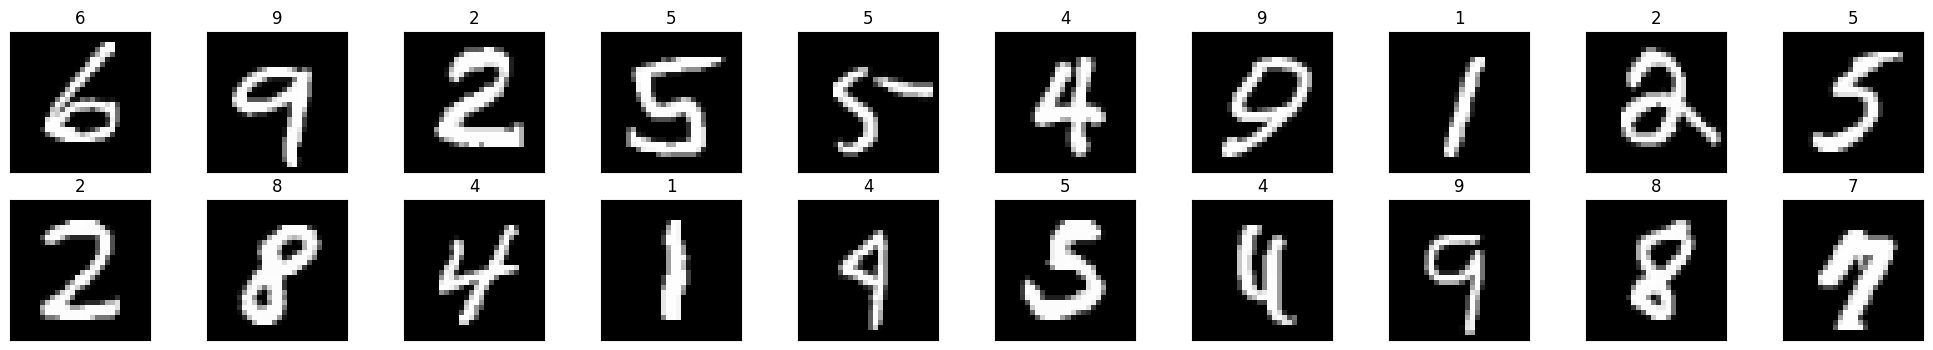

In [89]:
train_loader, test_loader, valid_loader = get_dataloader(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
plot_dataset(train_loader)

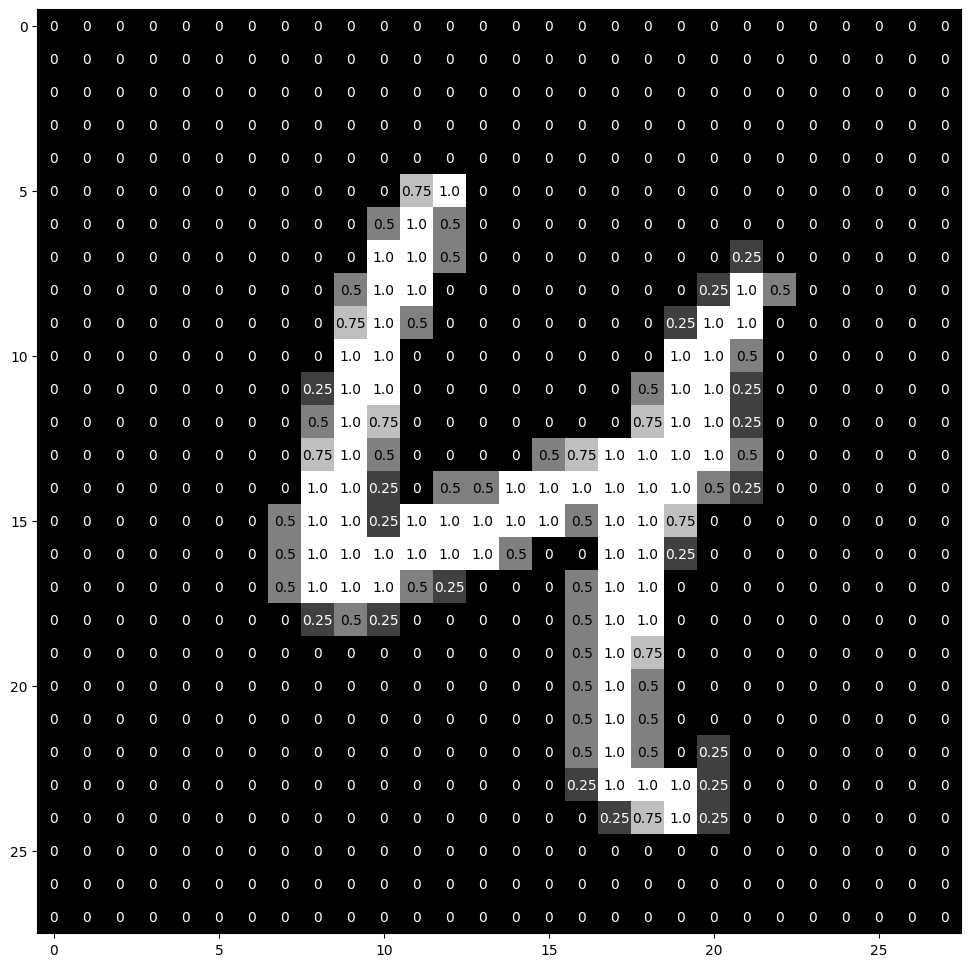

In [90]:
plot_single_data(train_loader)

### Simple CNN architecture

In [91]:
class CNNNet(nn.Module):
    def __init__(self, in_channels =1, num_classes=10):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels= 8, kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels= 16, kernel_size=(3,3),stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16*7*7, num_classes)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

### Utils section

In [92]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    total = labels.size(0)
    accuracy= correct / total
    return accuracy , correct, total

In [93]:
def precision_recall_f1(outputs, labels, num_classes=10):
    TP = torch.zeros(num_classes)
    FP = torch.zeros(num_classes)
    FN = torch.zeros(num_classes)
    
    _, preds = torch.max(outputs, 1)
    
    for i in range(num_classes):
        TP[i] = torch.sum((preds == i) & (labels == i)).item()
        FP[i] = torch.sum((preds == i) & (labels != i)).item()
        FN[i] = torch.sum((preds != i) & (labels == i)).item()

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    
    return avg_precision, avg_recall, avg_f1

In [94]:
def confusion_matrix(outputs, labels, num_classes=10):
    _, preds = torch.max(outputs, 1)
    cm = torch.zeros(num_classes, num_classes)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1
    
    return cm

#### Saving and Loading Model

In [95]:
def save_checkpoint(filepath, model, optimizer, train_acc, train_loss, epoch):
    save_state = {
        "state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer": optimizer.state_dict(),
        "loss": train_loss,
        "acc": train_acc,
    }
    print()
    print("Saving current parameters")
    print("___________________________________________________________")

    torch.save(save_state, filepath)

In [96]:
def load_model(filepath, model, optimizer):
    start_epoch = 1  # Initialize start_epoch to 1
    best_acc = 0.0   # Initialize best accuracy to 0
    valid_loss_min = np.Inf  # Initialize the best validation loss to infinity
    
    if filepath and os.path.isfile(filepath):
           
        print("=> loading checkpoint")
        checkpoint = torch.load(filepath)
        start_epoch = checkpoint["epoch"]
        best_acc = checkpoint["acc"]
        valid_loss_min = checkpoint["loss"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(
            "=> loaded checkpoint (epoch {})".format(
                checkpoint["epoch"]
            )
        )
    else:
        print("No pretrained model. Starting from scratch!")
    
    return model, optimizer, start_epoch, best_acc, valid_loss_min

In [118]:
def check_accuracy(model, device, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []
    valid_loss = 0.0
    n=len(test_loader)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)

            loss = criterion(outputs, target)
            valid_loss += loss.item()

            # Accumulate predictions and labels
            all_outputs.append(outputs)
            all_labels.append(target)

            # Calculate accuracy for the current batch
            correct += (outputs.argmax(1) == target).sum().item()
            total += target.size(0)

    # Convert list of tensors to single tensor
    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    # Accuracy
    acc = correct / total
    # print(f'Accuracy: {acc * 100:.2f}%')

    # Precision, Recall, F1-Score
    precision, recall, f1 = precision_recall_f1(all_outputs, all_labels, num_classes=10)
    # print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_outputs, all_labels, num_classes=10)
    # print(f'Confusion Matrix:\n{cm}')

    valid_loss=valid_loss/n 

    return acc, precision, recall, f1, cm, valid_loss

### Specify Loss Function and Optimizer

In [98]:
model= CNNNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Train Network

In [119]:
def train_network(model, optimizer, n_epochs, train_loader, valid_loader, filepath=CHECKPOINT_PATH):

    train_loss = 0.0
    avg_train_losses = []
    avg_valid_losses = []
    avg_train_acc = []
    avg_valid_acc = []
    total=len(train_loader)

    model, optimizer, start_epoch, best_acc, valid_loss_min = load_model(filepath=filepath, model=model, optimizer=optimizer)

    for epoch in range(start_epoch, n_epochs + 1):

        model.train()
        correct_train = 0
        total_train = 0
        
        for batch, (data, target) in enumerate(tqdm(train_loader), 1):

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)  # calculate the loss

            loss.backward()  # backward pass: compute gradient of the loss with respect to model parameters

            optimizer.step()  # perform a single optimization step (parameter update)

            # record training loss
            train_loss+=loss.item()

            # Calculate training accuracy
            _, correct_batch, total_batch = calculate_accuracy(output, target)
            correct_train += correct_batch
            total_train += total_batch

        # validate the model
        valid_accuracy, precision, recall, f1, cm, valid_loss = check_accuracy(model=model, device=device, test_loader=valid_loader, criterion=criterion)
        

        # calculate average loss, accuracy over an epoch
        train_loss = train_loss/total


        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

         # Calculate and store training accuracy
        train_accuracy = 100 * correct_train / total_train
        avg_train_acc.append(train_accuracy)

        # Calculate and store validation accuracy
        avg_valid_acc.append(valid_accuracy)
       

        epoch_len = len(str(n_epochs))

        print_msg = (f"[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] "
                     f"train_loss: {train_loss:.5f} "
                     f"train_acc: {train_accuracy:.2f}% "
                     f"valid_loss: {valid_loss:.5f} "
                     f"valid_acc: {valid_accuracy:.2f}%")

        print(print_msg)

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    valid_loss_min, valid_loss
                )
            )
            save_checkpoint(filepath=filepath,model=model, optimizer=optimizer,train_acc=valid_accuracy, train_loss=valid_loss, epoch=epoch)
            valid_loss_min = valid_loss

    return model, avg_train_losses, avg_valid_losses

In [120]:
model, train_loss, valid_loss = train_network(model, optimizer, 3, train_loader, valid_loader)

No pretrained model. Starting from scratch!


100%|██████████| 2400/2400 [00:23<00:00, 101.79it/s]


[1/3] train_loss: 0.18469 train_acc: 94.64% valid_loss: 0.17474 valid_acc: 0.95%
Validation loss decreased (inf --> 0.174741).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 2400/2400 [00:15<00:00, 150.16it/s]


[2/3] train_loss: 0.17449 train_acc: 94.93% valid_loss: 0.16692 valid_acc: 0.95%
Validation loss decreased (0.174741 --> 0.166918).  Saving model ...

Saving current parameters
___________________________________________________________


100%|██████████| 2400/2400 [00:54<00:00, 44.11it/s] 


[3/3] train_loss: 0.16527 train_acc: 95.21% valid_loss: 0.15755 valid_acc: 0.96%
Validation loss decreased (0.166918 --> 0.157551).  Saving model ...

Saving current parameters
___________________________________________________________


In [121]:
torchinfo.summary(model, input_size=(BATCH_SIZE, 1, 28, 28), col_names= ("input_size", "output_size"))

Layer (type:depth-idx)                   Input Shape               Output Shape
CNNNet                                   [20, 1, 28, 28]           [20, 10]
├─Conv2d: 1-1                            [20, 1, 28, 28]           [20, 8, 28, 28]
├─MaxPool2d: 1-2                         [20, 8, 28, 28]           [20, 8, 14, 14]
├─Conv2d: 1-3                            [20, 8, 14, 14]           [20, 16, 14, 14]
├─MaxPool2d: 1-4                         [20, 16, 14, 14]          [20, 16, 7, 7]
├─Linear: 1-5                            [20, 784]                 [20, 10]
Total params: 9,098
Trainable params: 9,098
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.99
Input size (MB): 0.06
Forward/backward pass size (MB): 1.51
Params size (MB): 0.04
Estimated Total Size (MB): 1.61

In [124]:
train_loss, valid_loss

([0.18469389922218396, 0.17449297963572996, 0.16526543166594318],
 [0.17474119919507453, 0.16691844945695872, 0.1575508203000451])

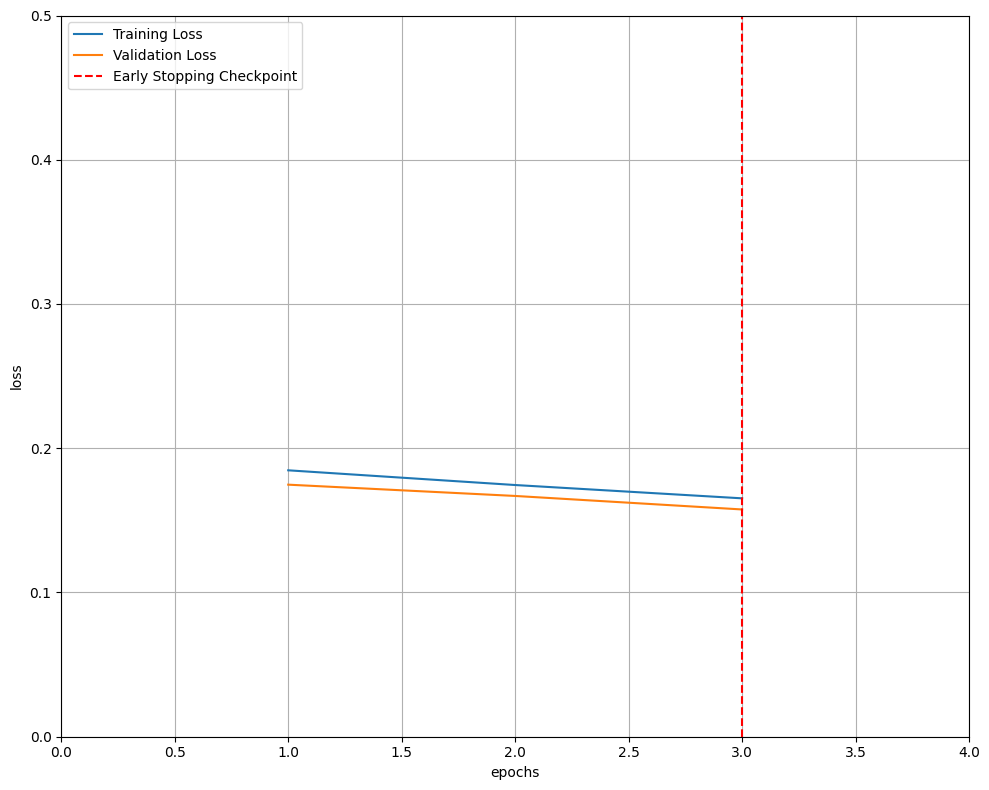

In [125]:
plot_loss(train_loss=train_loss,valid_loss=valid_loss)

### Evaluation

In [128]:
acc, precision, recall, f1, cm, loss = check_accuracy(model=model, device=device,test_loader=test_loader, criterion=criterion)

In [130]:
print(f'Accuracy: {acc * 100:.2f}%')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy: 95.63%
Precision: 0.9558, Recall: 0.9560, F1-Score: 0.9559


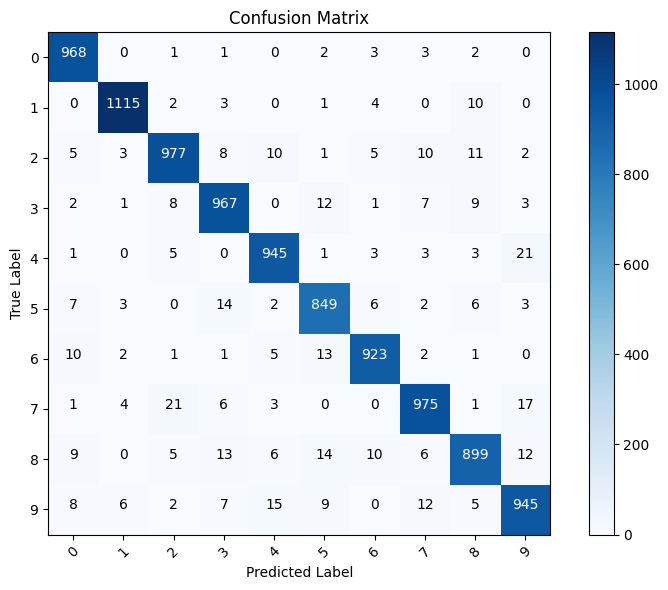

In [129]:
plot_confusion_matrix(cm)